<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/cabai_rawit_hijau_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## load data

In [2]:
url = 'https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f60a3db5fa0>)

In [3]:
dataset = pd.read_csv('data_pangan.csv', index_col='date', parse_dates=True)
dataset

,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,daging_sapi_kualitas_2,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
date,,,,,,,,,,,,,,,,,,,,,
2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,111550,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,109850,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,113650,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,111550,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,111150,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-02,11800,10750,10500,11800,11600,13100,12650,35650,128700,119350,...,49750,44950,53000,18750,17500,19750,18400,14800,15550,14250
2022-11-03,11800,10750,10450,11800,11600,13100,12650,36250,130950,121850,...,60250,47900,72400,19350,17050,20600,19550,14750,15450,14200
2022-11-04,11800,10700,10450,11800,11600,13100,12650,37500,133850,124200,...,52400,46350,57200,24300,19900,26400,25550,15250,15850,14750


In [4]:
train = dataset.cabai_rawit_hijau.values
date = dataset.index.values

## train_split

In [5]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'jumlah train data = {len(x_train)}\njumlah test data = {len(x_test)}\njumlah data validation = {len(x_val)}')

jumlah train data = 818
jumlah test data = 234
jumlah data validation = 117


## data generator

In [6]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

In [7]:
scal_range = MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))

data_train = time_step_generator(train_scal, time_size=400, shuffle_data=100, batch_size=5)
data_val = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=2)
data_test = time_step_generator(test_scal, time_size=100, shuffle_data=100, batch_size=5)

In [8]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
# win_size= 400
# win_size1 = 60
win_size=150
test_cabairawithijau_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## modeling

### model 1

In [9]:
model = Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Adam

In [10]:
model.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['mae', 'mape'])

In [11]:
history = model.fit(data_train, epochs=50, validation_data=data_val)

Epoch 1/50
84/84 [==============================] - 33s 228ms/step - loss: 0.0513 - mae: 0.1567 - mape: 155.0673 - val_loss: 0.0924 - val_mae: 0.2609 - val_mape: 68.9106
Epoch 2/50
84/84 [==============================] - 12s 138ms/step - loss: 0.0383 - mae: 0.1396 - mape: 137.4533 - val_loss: 0.0792 - val_mae: 0.2332 - val_mape: 70.4559
Epoch 3/50
84/84 [==============================] - 11s 135ms/step - loss: 0.0365 - mae: 0.1351 - mape: 134.2051 - val_loss: 0.0858 - val_mae: 0.2487 - val_mape: 69.9306
Epoch 4/50
84/84 [==============================] - 12s 137ms/step - loss: 0.0377 - mae: 0.1384 - mape: 135.0839 - val_loss: 0.0691 - val_mae: 0.2186 - val_mape: 77.7664
Epoch 5/50
84/84 [==============================] - 12s 137ms/step - loss: 0.0371 - mae: 0.1375 - mape: 131.2495 - val_loss: 0.0738 - val_mae: 0.2228 - val_mape: 72.9840
Epoch 6/50
84/84 [==============================] - 13s 152ms/step - loss: 0.0368 - mae: 0.1379 - mape: 146.4178 - val_loss: 0.0710 - val_mae: 0.2175 

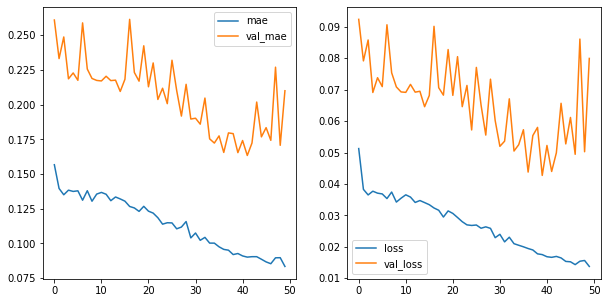

In [12]:
mae_hist = history.history['mae']
val_mae_hist = history.history['val_mae']
loss_hist = history.history['loss']
val_loss_hist = history.history['val_loss']

epochs = range(len(mae_hist))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, mae_hist, label='mae')
plt.plot(epochs, val_mae_hist, label='val_mae')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_hist, label='loss')
plt.plot(epochs, val_loss_hist, label='val_loss')
plt.legend()

181/181 [==============================] - 3s 12ms/step
mae 7643.298828125
mape 16.802661895751953
rmse 9895.471691637544


,actual,prediction
0,45300,32390.945312
1,43500,32574.859375
2,42100,35025.816406
3,41450,33717.207031
4,40750,35521.328125
...,...,...
229,44950,39881.257812
230,47900,49995.464844
231,46350,36692.511719
232,54350,43600.468750


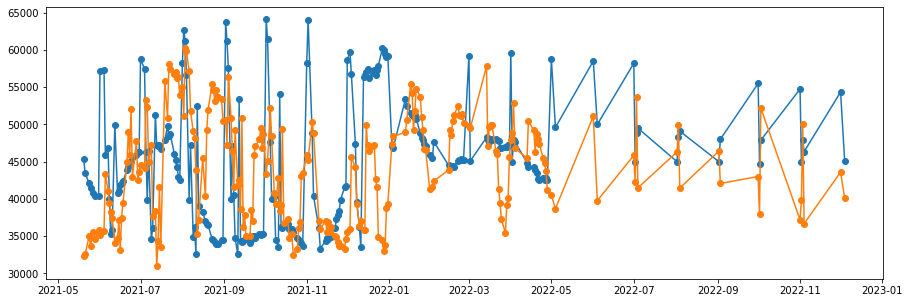

In [13]:
prediction_1_adam = forecast_predict(model, test_cabairawithijau_, time_size=win_size, batch_size=5)
data_result_1_adam = prediction_1_adam[(len(x_train)) - win_size:-1, -1]
data_result_1_adam = scal_range.inverse_transform(data_result_1_adam.reshape(-1, 1))
data_result_1_adam = data_result_1_adam.reshape(-1)
mae_1_adam = mean_absolute_error(x_test, data_result_1_adam)
mape_1_adam = mean_absolute_percentage_error(x_test, data_result_1_adam)
mse_1_adam = mean_squared_error(x_test, data_result_1_adam)
rmse_1_adam = math.sqrt(mse_1_adam)

print(f'mae {mae_1_adam.numpy()}\nmape {mape_1_adam.numpy()}\nrmse {rmse_1_adam}')

data_1_adam = pd.DataFrame()
data_1_adam['actual'] = x_test
data_1_adam['prediction'] = data_result_1_adam
data_1_adam.to_csv('cabairawithijau_1_adam.csv')

plt.figure(figsize=(15,5))
plt.plot(y_test, data_1_adam.actual, '-o', label='actual')
plt.plot(y_test, data_1_adam.prediction, '-o',label='prediction')
data_1_adam

#### SGD

In [14]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])

In [15]:
history1 = model.fit(data_train, epochs=50, validation_data=data_val)

Epoch 1/50
84/84 [==============================] - 18s 161ms/step - loss: 0.0137 - mae: 0.0856 - mape: 87.2047 - val_loss: 0.0785 - val_mae: 0.2091 - val_mape: 67.1556
Epoch 2/50
84/84 [==============================] - 12s 140ms/step - loss: 0.0128 - mae: 0.0824 - mape: 84.0914 - val_loss: 0.0771 - val_mae: 0.2080 - val_mape: 66.1192
Epoch 3/50
84/84 [==============================] - 12s 145ms/step - loss: 0.0124 - mae: 0.0806 - mape: 81.8740 - val_loss: 0.0758 - val_mae: 0.2068 - val_mape: 65.2446
Epoch 4/50
84/84 [==============================] - 12s 148ms/step - loss: 0.0121 - mae: 0.0790 - mape: 80.8000 - val_loss: 0.0742 - val_mae: 0.2052 - val_mape: 64.6117
Epoch 5/50
84/84 [==============================] - 12s 142ms/step - loss: 0.0119 - mae: 0.0783 - mape: 80.6563 - val_loss: 0.0729 - val_mae: 0.2038 - val_mape: 63.9940
Epoch 6/50
84/84 [==============================] - 12s 141ms/step - loss: 0.0117 - mae: 0.0774 - mape: 79.7307 - val_loss: 0.0719 - val_mae: 0.2026 - val_

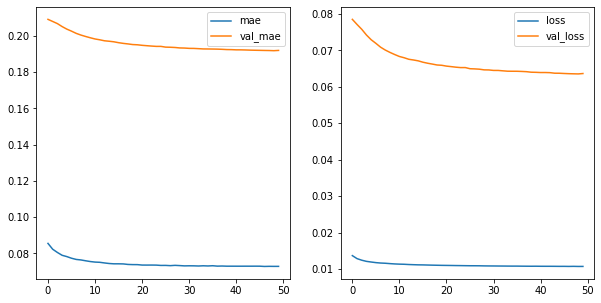

In [16]:
mae_hist_1 = history1.history['mae']
val_mae_hist_1 = history1.history['val_mae']
loss_hist_1 = history1.history['loss']
val_loss_hist_1 = history1.history['val_loss']

epochs_1 = range(len(mae_hist_1))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_1, mae_hist_1, label='mae')
plt.plot(epochs_1, val_mae_hist_1, label='val_mae')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_1, loss_hist_1, label='loss')
plt.plot(epochs_1, val_loss_hist_1, label='val_loss')
plt.legend()

181/181 [==============================] - 3s 12ms/step
mae 7477.8408203125
mape 16.147218704223633
rmse 9896.915883243628


,actual,prediction
0,45300,32429.587891
1,43500,32694.564453
2,42100,35140.906250
3,41450,33887.953125
4,40750,35783.406250
...,...,...
229,44950,43204.988281
230,47900,52858.847656
231,46350,40355.832031
232,54350,44068.562500


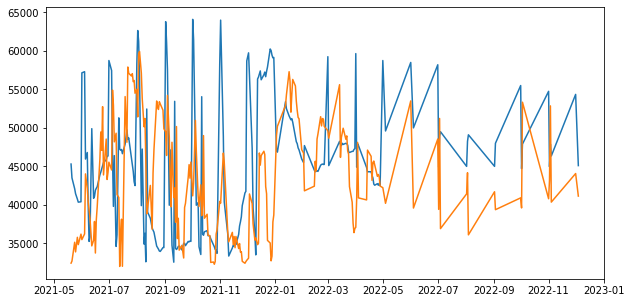

In [17]:
prediction_1_sgd = forecast_predict(model, test_cabairawithijau_, time_size=win_size, batch_size=5)
data_result_1_sgd = prediction_1_sgd[(len(x_train)) - win_size:-1, -1]
data_result_1_sgd = scal_range.inverse_transform(data_result_1_sgd.reshape(-1, 1))
data_result_1_sgd = data_result_1_sgd.reshape(-1)
mae_1_sgd = mean_absolute_error(x_test, data_result_1_sgd)
mape_1_sgd = mean_absolute_percentage_error(x_test, data_result_1_sgd)
mse_1_sgd = mean_squared_error(x_test, data_result_1_sgd)
rmse_1_sgd = math.sqrt(mse_1_sgd)

print(f'mae {mae_1_sgd.numpy()}\nmape {mape_1_sgd.numpy()}\nrmse {rmse_1_sgd}')

data_1_sgd = pd.DataFrame()
data_1_sgd['actual'] = x_test
data_1_sgd['prediction'] = data_result_1_sgd
data_1_sgd.to_csv('cabairawithijau_1_sgd.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_1_sgd.actual)
plt.plot(y_test, data_1_sgd.prediction)
data_1_sgd

### Model 2

In [18]:
model1= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                20224     
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                      

#### Adam

In [19]:
model1.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['mae', 'mape'])

In [20]:
history2 = model1.fit(data_train, epochs=400, validation_data=data_val)

Epoch 1/400
84/84 [==============================] - 12s 96ms/step - loss: 0.0583 - mae: 0.1731 - mape: 159.8506 - val_loss: 0.1010 - val_mae: 0.2733 - val_mape: 66.8647
Epoch 2/400
84/84 [==============================] - 7s 83ms/step - loss: 0.0391 - mae: 0.1448 - mape: 129.3975 - val_loss: 0.0782 - val_mae: 0.2302 - val_mape: 68.9653
Epoch 3/400
84/84 [==============================] - 7s 83ms/step - loss: 0.0396 - mae: 0.1467 - mape: 156.0905 - val_loss: 0.0673 - val_mae: 0.2174 - val_mape: 81.0674
Epoch 4/400
84/84 [==============================] - 7s 85ms/step - loss: 0.0383 - mae: 0.1408 - mape: 135.2587 - val_loss: 0.0772 - val_mae: 0.2218 - val_mape: 94.6282
Epoch 5/400
84/84 [==============================] - 7s 83ms/step - loss: 0.0374 - mae: 0.1429 - mape: 130.9803 - val_loss: 0.1046 - val_mae: 0.2816 - val_mape: 66.8928
Epoch 6/400
84/84 [==============================] - 7s 84ms/step - loss: 0.0384 - mae: 0.1436 - mape: 138.4997 - val_loss: 0.0772 - val_mae: 0.2339 - val

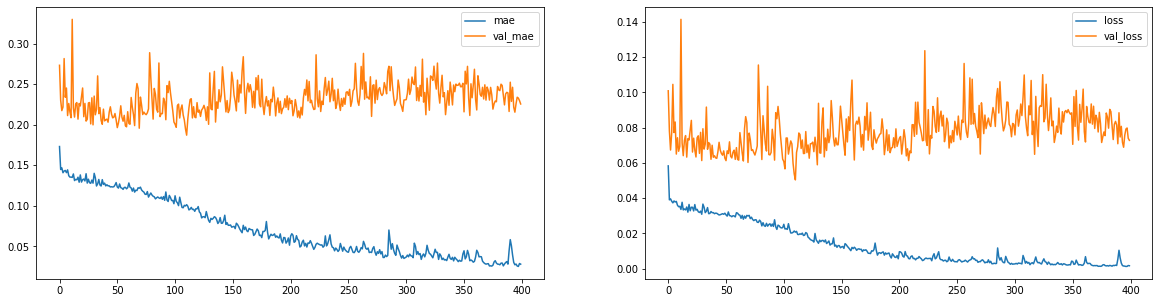

In [21]:
mae_hist_2 = history2.history['mae']
val_mae_hist_2 = history2.history['val_mae']
loss_hist_2 = history2.history['loss']
val_loss_hist_2 = history2.history['val_loss']

epochs2 = range(len(mae_hist_2))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs2, mae_hist_2, label='mae')
plt.plot(epochs2, val_mae_hist_2, label='val_mae')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs2, loss_hist_2, label='loss')
plt.plot(epochs2, val_loss_hist_2, label='val_loss')
plt.legend()

181/181 [==============================] - 2s 9ms/step
mae 7623.92626953125
mape 16.638315200805664
rmse 9887.214370084224


,actual,prediction
0,45300,31241.552734
1,43500,33232.343750
2,42100,33938.335938
3,41450,33066.429688
4,40750,34126.781250
...,...,...
229,44950,46465.949219
230,47900,54373.269531
231,46350,57947.457031
232,54350,58898.722656


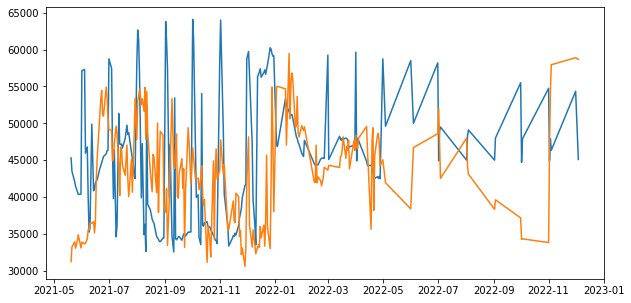

In [22]:
prediction_2_adam = forecast_predict(model1, test_cabairawithijau_, time_size=win_size, batch_size=5)
data_result_2_adam = prediction_2_adam[(len(x_train)) - win_size:-1, -1]
data_result_2_adam = scal_range.inverse_transform(data_result_2_adam.reshape(-1, 1))
data_result_2_adam = data_result_2_adam.reshape(-1)
mae_2_adam = mean_absolute_error(x_test, data_result_2_adam)
mape_2_adam = mean_absolute_percentage_error(x_test, data_result_2_adam)
mse_2_adam = mean_squared_error(x_test, data_result_2_adam)
rmse_2_adam = math.sqrt(mse_2_adam)

print(f'mae {mae_2_adam.numpy()}\nmape {mape_2_adam.numpy()}\nrmse {rmse_2_adam}')

data_2_adam = pd.DataFrame()
data_2_adam['actual'] = x_test
data_2_adam['prediction'] = data_result_2_adam
data_2_adam.to_csv('cabairawithijau_2_adam.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_2_adam.actual)
plt.plot(y_test, data_2_adam.prediction)
data_2_adam

#### SGD

In [23]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])

In [24]:
history3 = model1.fit(data_train, epochs=400, validation_data=data_val)

Epoch 1/400
84/84 [==============================] - 7s 84ms/step - loss: 0.0012 - mae: 0.0249 - mape: 27.2341 - val_loss: 0.0707 - val_mae: 0.2200 - val_mape: 52.7822
Epoch 2/400
84/84 [==============================] - 7s 85ms/step - loss: 0.0013 - mae: 0.0262 - mape: 28.3386 - val_loss: 0.0762 - val_mae: 0.2297 - val_mape: 53.4879
Epoch 3/400
84/84 [==============================] - 7s 84ms/step - loss: 0.0019 - mae: 0.0293 - mape: 30.5377 - val_loss: 0.0690 - val_mae: 0.2143 - val_mape: 55.0663
Epoch 4/400
84/84 [==============================] - 7s 84ms/step - loss: 0.0012 - mae: 0.0257 - mape: 26.9575 - val_loss: 0.0828 - val_mae: 0.2402 - val_mape: 56.0590
Epoch 5/400
84/84 [==============================] - 7s 84ms/step - loss: 0.0017 - mae: 0.0266 - mape: 30.2243 - val_loss: 0.0834 - val_mae: 0.2471 - val_mape: 61.7254
Epoch 6/400
84/84 [==============================] - 7s 83ms/step - loss: 0.0025 - mae: 0.0318 - mape: 31.5247 - val_loss: 0.0841 - val_mae: 0.2424 - val_mape: 

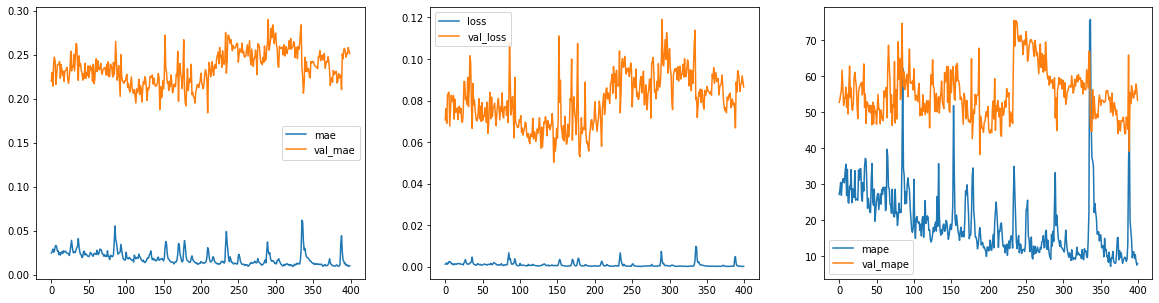

In [25]:
mae_hist_3 = history3.history['mae']
val_mae_hist_3 = history3.history['val_mae']
loss_hist_3 = history3.history['loss']
val_loss_hist_3 = history3.history['val_loss']
mape_hist_3 = history3.history['mape']
val_mape_hist_3 = history3.history['val_mape']

epochs3 = range(len(mae_hist_3))

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs3, mae_hist_3, label='mae')
plt.plot(epochs3, val_mae_hist_3, label='val_mae')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(epochs3, loss_hist_3, label='loss')
plt.plot(epochs3, val_loss_hist_3, label='val_loss')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(epochs3, mape_hist_3, label='mape')
plt.plot(epochs3, val_mape_hist_3, label='val_mape')
plt.legend()

181/181 [==============================] - 2s 9ms/step
mae 8100.986328125
mape 17.94527816772461
rmse 10448.119448015514


,actual,prediction
0,45300,33699.070312
1,43500,37099.042969
2,42100,31368.013672
3,41450,31191.658203
4,40750,32017.611328
...,...,...
229,44950,51077.683594
230,47900,38961.109375
231,46350,57378.054688
232,54350,56593.132812


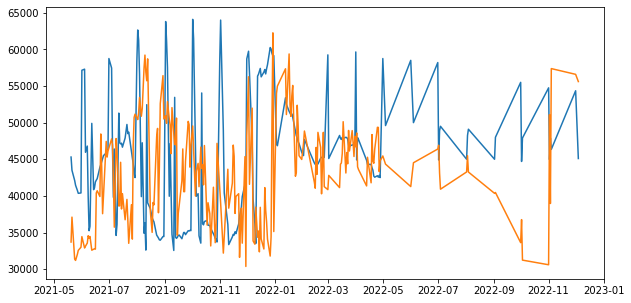

In [26]:
prediction_2_sgd = forecast_predict(model1, test_cabairawithijau_, time_size=win_size, batch_size=5)
data_result_2_sgd = prediction_2_sgd[(len(x_train)) - win_size:-1, -1]
data_result_2_sgd = scal_range.inverse_transform(data_result_2_sgd.reshape(-1, 1))
data_result_2_sgd = data_result_2_sgd.reshape(-1)
mae_2_sgd = mean_absolute_error(x_test, data_result_2_sgd)
mape_2_sgd = mean_absolute_percentage_error(x_test, data_result_2_sgd)
mse_2_sgd = mean_squared_error(x_test, data_result_2_sgd)
rmse_2_sgd = math.sqrt(mse_2_sgd)

print(f'mae {mae_2_sgd.numpy()}\nmape {mape_2_sgd.numpy()}\nrmse {rmse_2_sgd}')

data_2_sgd = pd.DataFrame()
data_2_sgd['actual'] = x_test
data_2_sgd['prediction'] = data_result_2_sgd
data_2_sgd.to_csv('cabairawithijau_2_sgd.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_2_sgd.actual)
plt.plot(y_test, data_2_sgd.prediction)
data_2_sgd